<a href="https://colab.research.google.com/github/julioagarcia/1DMT/blob/main/SyntheticDataset1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import required packages

import numpy as np
from SimPEG.electromagnetics import natural_source as nsem
from SimPEG import maps
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from SimPEG.utils import plot_1d_layer_model
from discretize import TensorMesh
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
matplotlib.rcParams['font.size'] = 14
import torch
from torch.utils.data import Dataset, DataLoader
import random
import normflows as nf
import scipy
from scipy.stats import truncnorm
from scipy.interpolate import CubicSpline, PchipInterpolator
import time

In [ ]:
#Forward modelling function from SimPEG

def run_forward(layer_thicknesses, rho_layers, frequencies, relative_error_rho=0.05, floor_phase=2):
    mesh = TensorMesh([(np.r_[layer_thicknesses, layer_thicknesses[-1]])], "N")

    wire_map = maps.Wires(("sigma", mesh.nC), ("t", mesh.nC - 1))
    sigma_map = maps.ExpMap(nP=mesh.nC) * wire_map.sigma
    layer_map = maps.ExpMap(nP=mesh.nC - 1) * wire_map.t


    sigma_map = maps.ExpMap(nP=len(rho_layers))

    receivers_list = [
        nsem.receivers.PointNaturalSource(component="app_res"),
        nsem.receivers.PointNaturalSource(component="phase"),
    ]

    source_list = []
    for freq in frequencies:
        source_list.append(nsem.sources.Planewave(receivers_list, freq))

    survey = nsem.survey.Survey(source_list)

    simulation = nsem.simulation_1d.Simulation1DRecursive(
        survey=survey,
        sigmaMap=sigma_map,
        thicknesses=layer_thicknesses,
    )

    true_model = np.r_[np.log(1./rho_layers)]

    dpred = simulation.dpred(true_model)
    rho_app = dpred.reshape((len(frequencies), 2))[:,0]
    phase = dpred.reshape((len(frequencies), 2))[:,1]
    std = np.c_[abs(rho_app)*relative_error_rho, np.ones(len(phase))*floor_phase].flatten()
    noise = np.c_[np.random.randn(rho_app.size)*relative_error_rho*abs(rho_app), np.random.randn(rho_app.size)*floor_phase].flatten()
    dobs = dpred + noise
    return dobs

In [ ]:
#Defining input and output datasets. Training data size of 10000

num_entries = 250000
input_size = 56
output_size = 51

# Initialize empty arrays for input and target data. Input data has a size of 51 corresponding to the interpolated resistivity-depth model data. Target data has a size of 56 corresponding to the dobs data from SimPEG
input_data = np.zeros((num_entries, input_size))
target_data = np.zeros((num_entries, output_size))

In [ ]:
start_time = time.time()
#num_len = len(num_entries)
for i in range(num_entries):
    num_samples = random.randint(3,15)
    #Define Gaussian distribution

    mu, sigma = 1, 1.5 #mean and std deviation of the Gaussian distribution
    samples = (np.random.normal(mu, sigma, num_samples)) #sample the distribution
    samples[samples < -1] = -1
    samples[samples > 4] = 4

    #Convert the samples to a logarithmic scale [10^(samples)]

    samples_to_the_power_of_10 = np.power(10,samples)

    #Sample num_samples number of depths between 0 and 15,000 m
    depths = np.random.uniform(0,15000,num_samples)

    #Sort depths in order and then multiply by -1 to agree with SimPEG depth convention

    depths = np.sort(depths)
    depths = -depths

    #Spline interpolation for resistivity-depth model
    inter_depths = np.zeros(num_samples)
    depth_len = len(depths)
    inter_depths[0] = depths[0]/2 #First layer boundary is at half of the depth to sample the middle of the first layer and reduce extrapolation between surface
    for x in range(depth_len-1):  # Iterate through the elements of depths (except the last one)
        inter_depths[x+1] = (depths[x+1] + depths[x]) / 2   #Interpolate at the midpoints of layers
    inter_depths[depth_len-1] = -16000  #Final layer is at 16000m, creating halfspace effect from 0 to 15000m
    #Multiply depths by -1 to agree with SciPy interpolate convetion
    depths = -depths
    inter_depths = -inter_depths

    #Using PchipInterpolator to preserve monotonicity and acheive a more realistic interpolation function. Using 51 depth points increasing by 5 percent at each layer. Starting depth is 71.65104m, final depth is ~15000m

    mono = PchipInterpolator(inter_depths, samples)

    #Created 51 layer model with starting thickness of 72.45875m and increasing by 5% at each layer
    dz = 72.45875
    n_layer = 52
    z_factor = 1.05
    knots = dz*z_factor**np.arange(n_layer-2)[::1]
    knots = np.cumsum(knots)
    knots = np.insert(knots, 0, 0)
    mono_vals = mono(knots)
    mono_vals_to_the_power_of_10 = np.power(10,mono_vals)

    #Calculate layer properties

    layer_tops = np.r_[knots][::-1]  # in m
    layer_thicknesses = np.diff(knots)
    rho_layers = np.r_[mono_vals_to_the_power_of_10][::-1]

    #Setting frequencies to 28

    frequencies = np.logspace(-3, 3, 28)
    relative_error_rho = 0.05
    floor_phase = 2.
    dobs = run_forward(layer_thicknesses, rho_layers, frequencies, relative_error_rho=relative_error_rho, floor_phase=floor_phase)


    #if (mono_vals[0] > -1 and mono_vals[0] < 4):
    target_data[i-1] =  mono_vals
    input_data[i-1] = dobs
    #plt.figure()
    #plt.plot(samples,inter_depths, 'o', label='Data points')
    #plt.plot(values,knots, '-', label='Cubic Spline Interpolation')
    #plt.plot(mono_vals,knots, '-', label='PChip Interpolation')
    #plt.legend()
    #plt.xlabel('Resistivity ($\Omega$m)')
    #plt.xscale("log")
    #plt.ylabel('Depth')
    #plt.xlim(-1, 5)
    #plt.show()

c:\users\diana22\documents\andrew\houston geophysics\simpeg\simpeg\SimPEG\electromagnetics\natural_source\simulation_1d.py:77: RuntimeWarning: overflow encountered in tanh
  tanhs = np.tanh(alphas[:-1] * thicknesses[:, None])


In [ ]:
# Create a boolean mask to identify rows to keep
mask = (target_data[:, 0] <= 4) & (target_data[:, 0] >= -1)

# Filter the target_data based on the mask
filtered_target_data = target_data[mask]
filtered_input_data = input_data[mask]

In [ ]:
np.savetxt('input_data.txt', filtered_input_data)
np.savetxt('target_data.txt', filtered_target_data)
torch.save(filtered_input_data, 'input_data.pt')
torch.save(filtered_target_data, 'target_data.pt')

In [ ]:
print(len(filtered_input_data))
print(len(filtered_target_data))

155220
155220


In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 1494.0465693473816 seconds ---


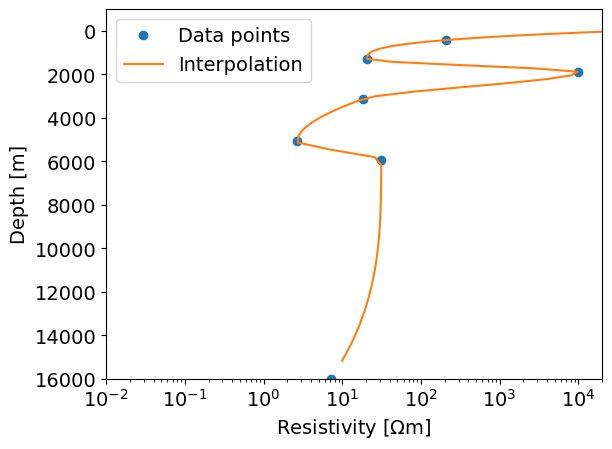

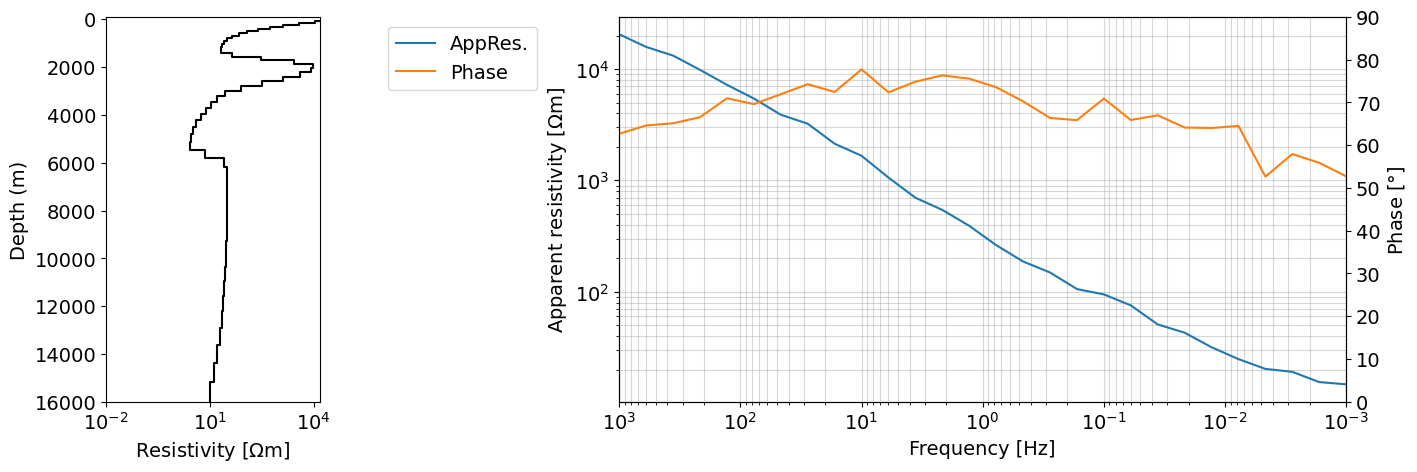

In [ ]:
#Plot interpolated resistivity model

mono_vals_to_the_power_of_10 = np.power(10,mono_vals)
plt.figure()
plt.plot(samples_to_the_power_of_10,inter_depths, 'o', label='Data points')
#plt.plot(values,knots, '-')
plt.plot(mono_vals_to_the_power_of_10,knots, '-', label='Interpolation')
plt.legend()
plt.xlabel('Resistivity [$\Omega$m]')
plt.xscale("log")
plt.ylabel('Depth [m]')
plt.ylim(16000,-1000)
plt.xlim(0.01, 20000)
plt.show()
#Display resistivity-depth model and forward modelled phase and apparent resistivities (pulled from SimPEG tutorial)

fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(1, 5, figure=fig)
ax0 = fig.add_subplot(gs[0, 0])
plot_1d_layer_model(layer_thicknesses[::1], rho_layers[::-1], ax=ax0, color="k", **{'label':'True'})
ax0.set_xlabel("Resistivity [$\Omega$m]")
ax0.set_xlim(0.01, 15000)
ax0.set_ylim(16000,-100)
# ax0.set_yscale('log')
ax = fig.add_subplot(gs[0, 2:])
ax.loglog(frequencies, dobs.reshape((len(frequencies), 2))[:,0], color='C0', label='AppRes.')
ax.loglog(frequencies[0], dobs.reshape((len(frequencies), 2))[0,0], color='C1', label='Phase')
ax_1 = ax.twinx()
ax_1.plot(frequencies, dobs.reshape((len(frequencies), 2))[:,1], color='C1')
ax.set_xlabel("Frequency [Hz]")
ax_1.set_ylim(0, 90)
ax.grid(True, which='both', alpha=0.5)
ax.set_ylabel("Apparent resistivity [$\Omega$m]")
ax_1.set_ylabel("Phase [$\degree$]")
ax.legend(bbox_to_anchor=(-0.1, 1))
#ax.set_xlim(100000,0.0001)
ax.set_xlim(frequencies.max(), frequencies.min())
plt.show()